In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
# from voltron.robinhood_utils import GetStockData
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle

sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.models import SingleTaskVariationalGP as SingleTaskCopulaProcessModel
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from voltron.means import LogLinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

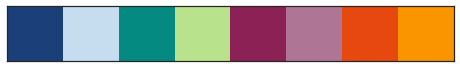

In [4]:
sns.palplot(palette)

In [5]:
with open("./stock_data.pkl", "rb") as handle:
    raw_data = pickle.load(handle)
    
tckr = "VIRT"
span = "5year"
interval = 'day'
T = 5.

data = raw_data[raw_data["symbol"] == tckr]

ts = torch.linspace(0, T, data.shape[0])
y = torch.FloatTensor(data['close_price'].to_numpy())


In [6]:
eval_times = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [7]:
prices_at_time_y = y[torch.tensor(eval_times)]
delta_y = prices_at_time_y[1:] - prices_at_time_y[:-1]

## Load Price Probabilities

In [8]:
voltron = torch.load("voltron_v.pt")
matern = torch.load("matern_v.pt")
specmix = torch.load("specmix_v.pt")

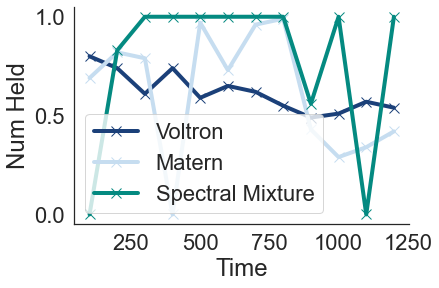

In [9]:
plt.plot(eval_times, voltron, marker = "x", markersize = 10, label = "Voltron")
plt.plot(eval_times, matern, marker = "x", markersize = 10, label = "Matern")
plt.plot(eval_times, specmix, marker = "x", markersize = 10, label = "Spectral Mixture")

plt.ylabel("Num Held")
plt.xlabel("Time")
plt.legend()
sns.despine()

Example Beta(17, 8) which is pretty right skewed.

In [10]:
from torch.distributions import Beta
from scipy.special import betainc

xs = torch.linspace(0, 1, 100)

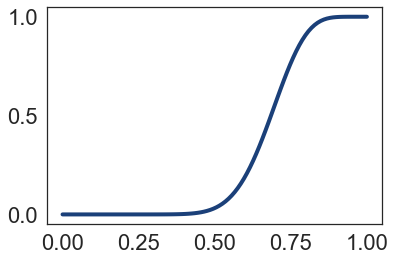

In [11]:
plt.plot(xs, betainc(17, 8, xs))

In [12]:
bought_func = lambda xs: betainc(17, 8, xs)
held_voltron = 1000 * bought_func(voltron)
held_matern = 1000 * bought_func(matern)
held_specmix = 1000 * bought_func(specmix)

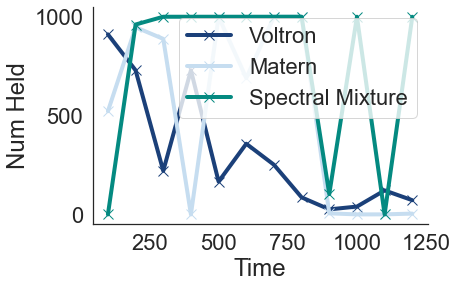

In [13]:
plt.plot(eval_times, held_voltron, marker = "x", markersize = 10, label = "Voltron")
plt.plot(eval_times, held_matern, marker = "x", markersize = 10, label = "Matern")
plt.plot(eval_times, held_specmix, marker = "x", markersize = 10, label = "Spectral Mixture")
plt.ylabel("Num Held")
plt.xlabel("Time")
plt.legend()
sns.despine()

reward is $\sum \Delta_y * Stocks$ 

In [14]:
def reward_risk(a, b, prob_incs):
    bought_func = lambda xs: betainc(a, b, xs)
    total_held = 1000 * bought_func(prob_incs)
    
    returns = total_held[1:] * delta_y
    #cum_returns = returns.cumsum(0)
    return returns.std(), returns.sum()

Randomly sample to find pareto fronts. ideally, we'd do BO or something like that but it's 2d.

In [15]:
vals = torch.rand(2500, 2) * 50
mtps_voltron = torch.tensor([reward_risk(x[0], x[1], voltron) for x in vals])
mtps_matern = torch.tensor([reward_risk(x[0], x[1], matern) for x in vals])
mtps_specmix = torch.tensor([reward_risk(x[0], x[1], specmix) for x in vals])

Voltron returns and SD of returns are normal.

[Text(61.0, 0.5, 'b'), Text(395.7999999999999, 0.5, 'b')]

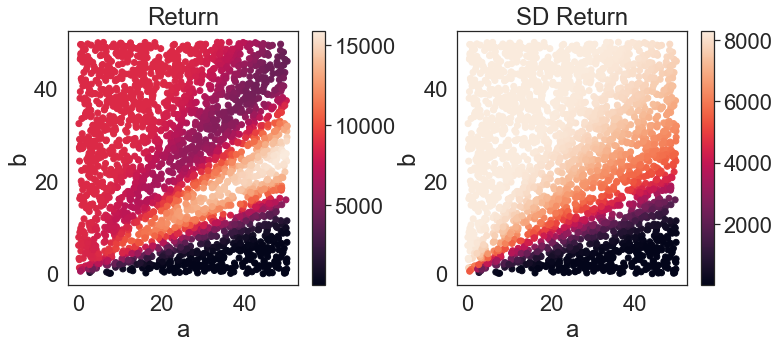

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (11, 5))
f = ax[0].scatter(vals[:,0], vals[:,1], c=mtps_voltron[:,1])
ax[0].set_title("Return")
fig.colorbar(f, ax=ax[0])

f = ax[1].scatter(vals[:,0], vals[:,1], c=mtps_voltron[:,0])
ax[1].set_title("SD Return")
fig.colorbar(f, ax = ax[1])
plt.tight_layout()

[ax[i].set_xlabel("a") for i in range(2)]
[ax[i].set_ylabel("b") for i in range(2)]

Matern is much more icky, mostly because we keep buying baskets of stocks.

[Text(61.0, 0.5, 'b'), Text(395.7999999999999, 0.5, 'b')]

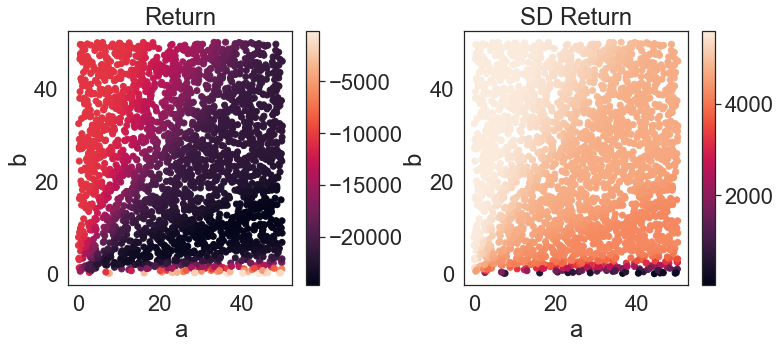

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (11, 5))
f = ax[0].scatter(vals[:,0], vals[:,1], c=mtps_matern[:,1])
ax[0].set_title("Return")
fig.colorbar(f, ax=ax[0])

f = ax[1].scatter(vals[:,0], vals[:,1], c=mtps_matern[:,0])
ax[1].set_title("SD Return")
fig.colorbar(f, ax = ax[1])
plt.tight_layout()

[ax[i].set_xlabel("a") for i in range(2)]
[ax[i].set_ylabel("b") for i in range(2)]

[Text(61.0, 0.5, 'b'), Text(395.7999999999999, 0.5, 'b')]

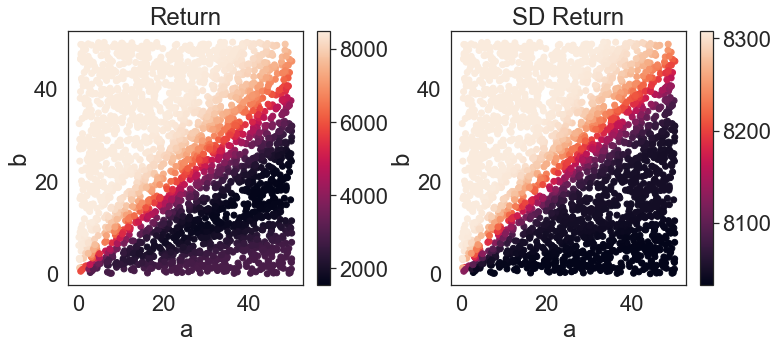

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (11, 5))
f = ax[0].scatter(vals[:,0], vals[:,1], c=mtps_specmix[:,1])
ax[0].set_title("Return")
fig.colorbar(f, ax=ax[0])

f = ax[1].scatter(vals[:,0], vals[:,1], c=mtps_specmix[:,0])
ax[1].set_title("SD Return")
fig.colorbar(f, ax = ax[1])
plt.tight_layout()

[ax[i].set_xlabel("a") for i in range(2)]
[ax[i].set_ylabel("b") for i in range(2)]

Plot pareto fronts.

In [19]:
from botorch.utils.multi_objective import is_non_dominated

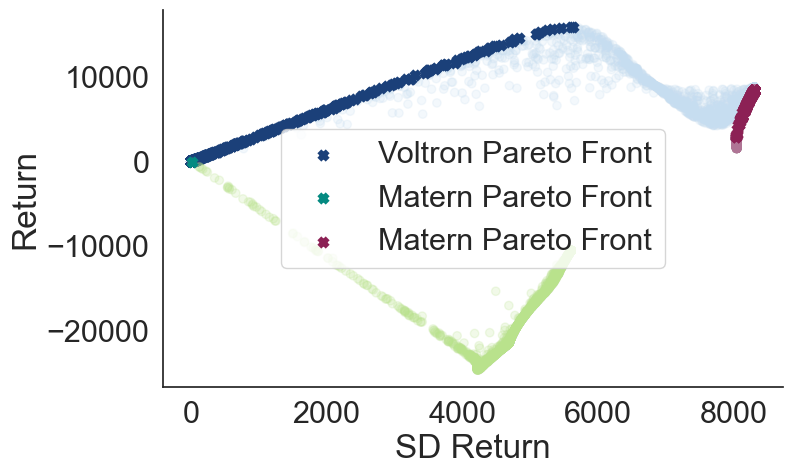

In [20]:
plt.figure(figsize = (8, 5), dpi = 100)

scaling = torch.ones(2)
scaling[0] = -1.
pf_bool_vol = is_non_dominated(mtps_voltron * scaling)
plt.scatter(*mtps_voltron.t(), alpha = 0.2, c = [palette[1]] * 2500)
plt.scatter(*mtps_voltron[pf_bool_vol].t(), label = "Voltron Pareto Front", color = palette[0], marker = "x")

pf_bool = is_non_dominated(mtps_matern * scaling)
plt.scatter(*mtps_matern.t(), alpha = 0.2, c = [palette[3]] * 2500)
plt.scatter(*mtps_matern[pf_bool].t(), label = "Matern Pareto Front", color = palette[2], marker = "x")

pf_bool_sm = is_non_dominated(mtps_specmix * scaling)
plt.scatter(*mtps_specmix.t(), alpha = 0.2, c = [palette[5]] * 2500)
plt.scatter(*mtps_specmix[pf_bool_sm].t(), label = "Matern Pareto Front", color = palette[4], marker = "x")

plt.ylabel("Return")
plt.xlabel("SD Return")
plt.legend()

sns.despine()

Show the buy functions corresponding to the pareto optimal sets.

Text(0, 0.5, '# of Stocks Held')

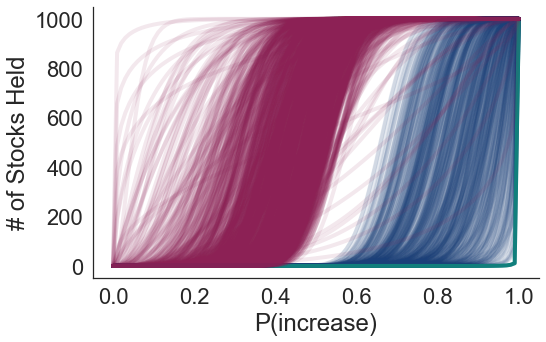

In [21]:
plt.subplots(figsize = (8, 5))
[plt.plot(xs, 1000. * betainc(*v, xs), color = palette[0], alpha = 0.1) for v in vals[pf_bool_vol]]
[plt.plot(xs, 1000. * betainc(*v, xs), color = palette[2], alpha = 1.0) for v in vals[pf_bool]]
[plt.plot(xs, 1000. * betainc(*v, xs), color = palette[4], alpha = 0.1) for v in vals[pf_bool_sm]]
sns.despine()
plt.xlabel("P(increase)")
plt.ylabel("# of Stocks Held")

Finally, show the pareto optimal points for the voltron ones.

[Text(61.0, 0.5, 'b'), Text(395.7999999999999, 0.5, 'b')]

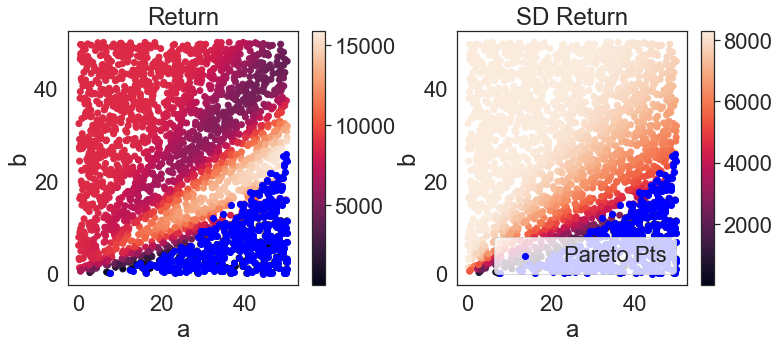

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (11, 5))
f = ax[0].scatter(vals[:,0], vals[:,1], c=mtps_voltron[:,1])
ax[0].scatter(vals[pf_bool_vol,0], vals[pf_bool_vol,1], color = "blue")
ax[0].set_title("Return")
fig.colorbar(f, ax=ax[0])

f = ax[1].scatter(vals[:,0], vals[:,1], c=mtps_voltron[:,0])
ax[1].scatter(vals[pf_bool_vol,0], vals[pf_bool_vol,1], color = "blue", label = "Pareto Pts")
ax[1].set_title("SD Return")
ax[1].legend(loc = "lower right")
fig.colorbar(f, ax = ax[1])
plt.tight_layout()

[ax[i].set_xlabel("a") for i in range(2)]
[ax[i].set_ylabel("b") for i in range(2)]

In [23]:
voltron

[tensor(0.8000),
 tensor(0.7400),
 tensor(0.6100),
 tensor(0.7400),
 tensor(0.5900),
 tensor(0.6500),
 tensor(0.6200),
 tensor(0.5500),
 tensor(0.4900),
 tensor(0.5100),
 tensor(0.5700),
 tensor(0.5400)]

In [24]:
prices_at_time_y

tensor([18.9000, 17.5000, 15.9000, 35.2000, 21.8000, 26.8800, 21.7000, 16.6700,
        23.6700, 27.3250, 27.5900, 27.6600])

In [25]:
bought_func(voltron)

array([0.91082877, 0.7290717 , 0.22038326, 0.7290717 , 0.16599621,
       0.35751542, 0.2512742 , 0.08629335, 0.02554779, 0.03962997,
       0.121481  , 0.07189631], dtype=float32)

In [26]:
base = 10000

In [27]:
prices_at_time_y = torch.tensor([y[0], *prices_at_time_y])

In [28]:
def value_func(vec, base = 10000):
    portfolio_value = torch.zeros(12)
    portfolio_value[0] = base
    for i in range(11):
        price_of_stock = portfolio_value[i] * bought_func(vec)[i]
        amt_bought = price_of_stock / prices_at_time_y[i]
        cash_left = portfolio_value[i] - price_of_stock
        portfolio_value[i+1] = cash_left + amt_bought * prices_at_time_y[i+1]
    return portfolio_value
    

In [29]:
hodl_strat = 10000 / y[0] * prices_at_time_y[1:]

Text(0, 0.5, 'Portfolio Value')

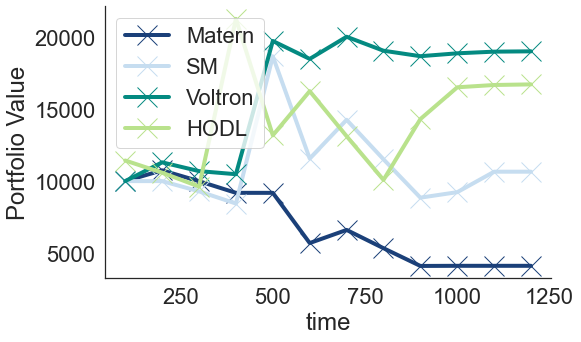

In [30]:
plt.figure(figsize = (8, 5))
plt.plot(eval_times, value_func(matern), label = "Matern", marker = "x", markersize = 20)
plt.plot(eval_times, value_func(specmix), label = "SM", marker = "x", markersize = 20)
plt.plot(eval_times, value_func(voltron), label = "Voltron", marker = "x", markersize = 20)
plt.plot(eval_times, hodl_strat, label = "HODL", marker = "x", markersize = 20)
plt.legend()
sns.despine()
plt.xlabel("time")
plt.ylabel("Portfolio Value")

In [31]:
eval_times = torch.tensor(eval_times) / 252

In [32]:
def running_sharpe_ratio(vec):
    returns = vec - 10000
    std_returns = torch.tensor([returns[:i].std(0) for i in range(len(vec))])
    # need avg return divided by sd of returns?
    return returns.cumsum(0) / std_returns / torch.arange(vec.shape[0])

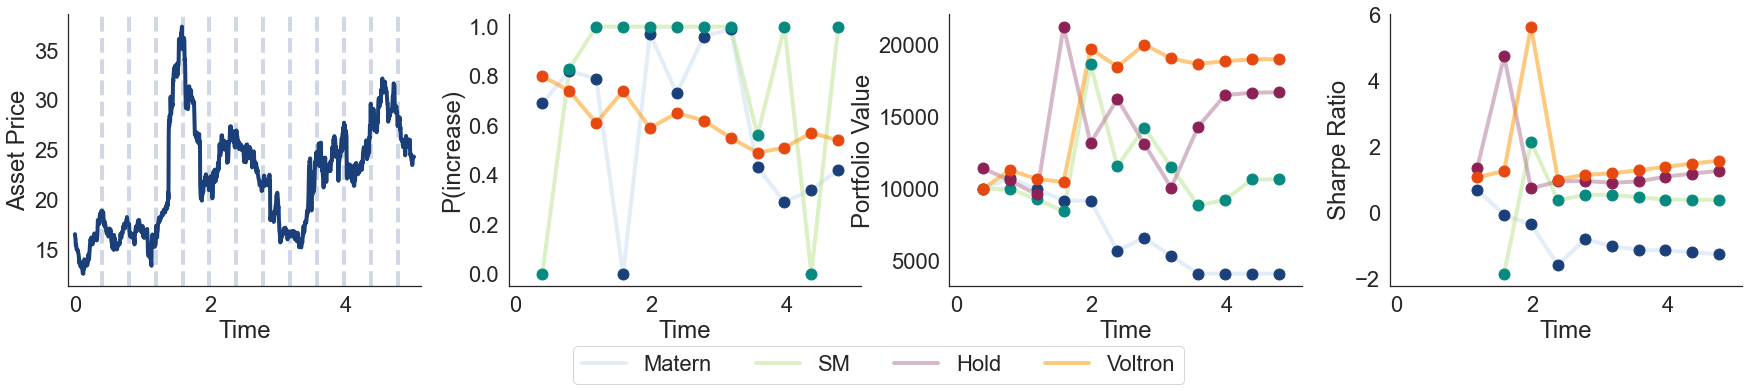

In [57]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))
ax[0].plot(ts, y)
[ax[i].set_xlabel("Time") for i in range(4)]
ax[0].set_ylabel("Asset Price")
[ax[0].axvline(x=eval_times[i], alpha = 0.2, linestyle="--") for i in range(len(eval_times))]

ax[1].plot(eval_times, matern, label = "Matern", color=palette[1], alpha = 0.5)
ax[1].plot(eval_times, specmix, label = "Spectral Mixture", color=palette[3], alpha = 0.5)
ax[1].plot(eval_times, voltron, label = "Voltron", color = palette[-1], alpha = 0.5)
ax[1].scatter(eval_times, matern, s = 120, label = "Matern", color=palette[0], zorder=4)
ax[1].scatter(eval_times, specmix, s = 120, label = "Spectral Mixture", color=palette[2], zorder=4)
ax[1].scatter(eval_times, voltron, s = 120, label = "Voltron", color = palette[-2], zorder=4)

ax[2].plot(eval_times, value_func(matern), label = "Matern", color=palette[1], alpha = 0.5)
ax[2].plot(eval_times, value_func(specmix), label = "SM", color=palette[3], alpha = 0.5)
ax[2].plot(eval_times, hodl_strat, label = "Hold", color=palette[5], alpha = 0.5)
ax[2].plot(eval_times, value_func(voltron), label = "Voltron", color = palette[-1], alpha = 0.5)
ax[2].scatter(eval_times, value_func(matern), color=palette[0], zorder=4, s=120)
ax[2].scatter(eval_times, value_func(specmix), color=palette[2], zorder=4, s=120)
ax[2].scatter(eval_times, hodl_strat,color=palette[4], zorder=4, s=120)
ax[2].scatter(eval_times, value_func(voltron),color = palette[-2], zorder=4, s=120)

ax[3].plot(eval_times, running_sharpe_ratio(value_func(matern)), 
           label = "Matern", color=palette[1], alpha = 0.5)
ax[3].plot(eval_times, running_sharpe_ratio(value_func(specmix)), 
           label = "SM", color=palette[3], alpha = 0.5)
ax[3].plot(eval_times, running_sharpe_ratio(hodl_strat), label = "HODL", markersize = 20,
          color=palette[5], alpha = 0.5)
ax[3].plot(eval_times, running_sharpe_ratio(value_func(voltron)), 
           label = "Voltron", color = palette[-1], alpha = 0.5)
ax[3].scatter(eval_times, running_sharpe_ratio(value_func(matern)), 
           s = 120, color=palette[0], zorder=4)
ax[3].scatter(eval_times, running_sharpe_ratio(value_func(specmix)), 
           s = 120, color=palette[2], zorder=4)
ax[3].scatter(eval_times, running_sharpe_ratio(hodl_strat),
             s = 120, color = palette[4], zorder=4)
ax[3].scatter(eval_times, running_sharpe_ratio(value_func(voltron)), 
           s = 120, color = palette[-2], zorder=4)


ax[1].set_ylabel("P(increase)")
ax[2].set_ylabel("Portfolio Value")
ax[3].set_ylabel("Sharpe Ratio")

ax[2].legend(ncol = 4, loc = "lower center", bbox_to_anchor = (-0.2, -0.4))
plt.subplots_adjust(wspace=0.25)
sns.despine()
[ax[i].set_xlim((-0.1, 5.1)) for i in range(4)]
plt.savefig("trading_strategy.pdf", bbox_inches = "tight")

In [99]:
ts.max()

tensor(5.)